# A.1. Transformación Bilineal

In [6]:
import os

import numpy             as np
import matplotlib.pyplot as plt

from scipy import signal

# output config
np.set_printoptions(suppress=True)

In [20]:
def freqz(b, a, sr=1000.):
    w, h = signal.freqz(b,a)
    H    = 20*np.log10(np.abs(h) + 1E-6)
    W    = np.angle  (h)
    W    = np.unwrap (W)
    W    = np.degrees(W)
    w    = np.linspace(0, sr/2, H.shape[0])
    #
    return w, W, H
#
def freqz_plot(b, a, sr, color='blue'):
    w, w_hz, h_hz = freqz(b, a, sr)
    #
    plt.figure('Magnitud', figsize=(8, 4))
    plt.title('Magnitud [dB]')
    plt.grid(True)
    plt.plot(w, h_hz, linewidth=3, color=color)
    #
    plt.figure('Fase', figsize=(8, 4))
    plt.title('Fase [grados]')
    plt.plot(w, w_hz, linewidth=3, color=color)
    plt.grid(True)

In [8]:
import sympy as sym

s, z, wc, T = sym.symbols('s z wc T')

# Diseño de filtros digitales

## Transformación bilineal
Objetivo: Transformar un filtro en el dominio analógico a uno equivalente en el dominio digital 
$$\mathcal{T}(H(s))\rightarrow H(z) $$

La transformación bilineal se define como
$$\mathcal{T}: s=\dfrac{2}{T} \dfrac{1 - z^{-1}}{1 + z^{-1}}$$

donde $T$ es el periodo de muestreo.

De esta forma la función de transferencia del filtro digital de orden N es
$$y[n] = \dfrac{\sum_{k=0}^N b_k z^{-k}}{\sum_{k=0}^N a_k z^{-k}}$$

### Transformación bilineal en filtro Butterworth
#### Caso: normalizado, orden 1

In [9]:
Hs = 1/(s + 1)
Hs

1/(s + 1)

In [10]:
bl = 2/T * (1 - z**(-1))/(1 + z**(-1))
bl

2*(1 - 1/z)/(T*(1 + 1/z))

In [18]:
Hz = Hs.subs(s, bl).expand().simplify().collect(z)
Hz

T*(z + 1)/(T + z*(T + 2) - 2)

Poniendo esta función de transferencia en términos de $z^{-1}$
$$H(z) = \dfrac{T + T z^{-1}}{(T+2) + (T-2)z^{-1}}$$

**Ejemplo 1.**

[0.05 0.05]
[ 2.05 -1.95]


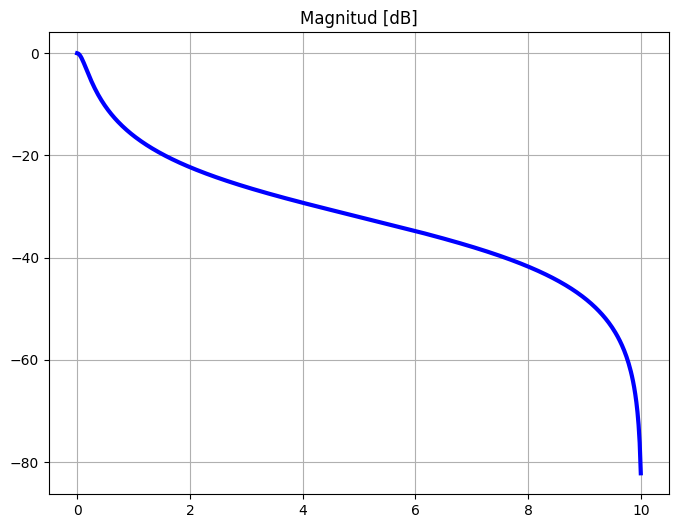

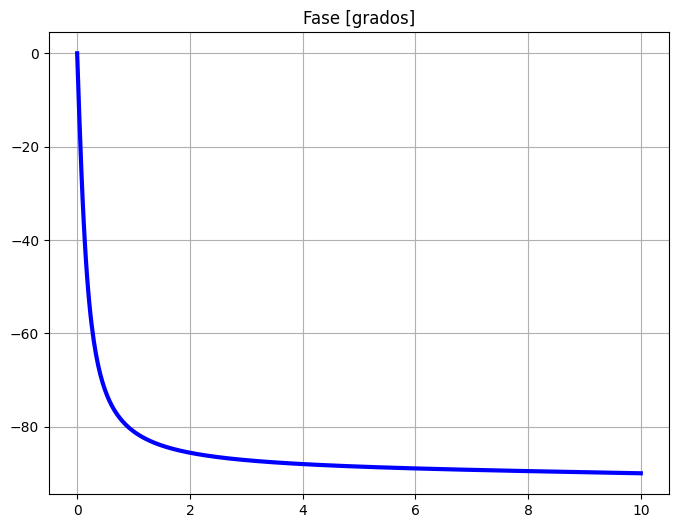

In [22]:
sr = 20
P = 1/sr
#
b = np.array([P, P])
a = np.array([P+2, P-2])
print(b)
print(a)
#
freqz_plot(b, a, sr)

#### Caso: normalizado, orden 2

In [23]:
Hs = 1/(s**2 + np.sqrt(2)*s + 1)
Hs

1/(s**2 + 1.4142135623731*s + 1)

In [25]:
Hz = Hs.subs(s, bl)\
       .simplify()\
       .expand()\
       .simplify()\
       .collect([z**2, z])
Hz

T**2*(z**2 + 2*z + 1)/(T**2 - 2.82842712474619*T + z**2*(T**2 + 2.82842712474619*T + 4) + z*(2*T**2 - 8) + 4)

[0.0025 0.005  0.0025]
[ 4.14392136 -7.995       3.86107864]


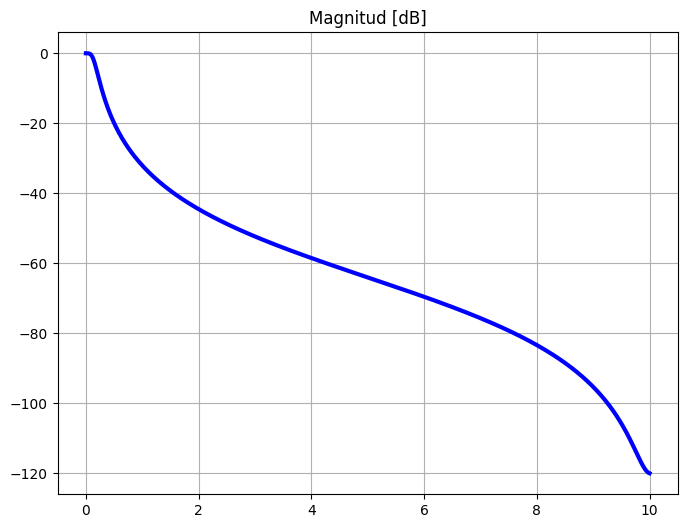

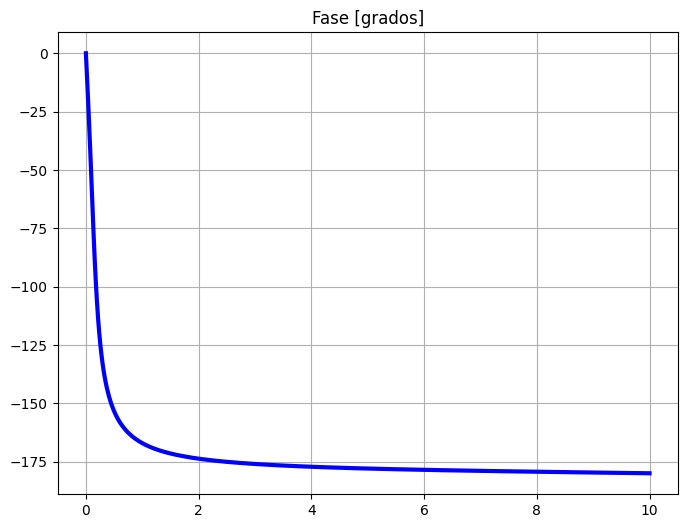

In [26]:
b = np.array([P**2, 2*P**2, P**2])
a = np.array([P**2 + 2*np.sqrt(2)*P + 4,
              2*P**2 - 8,
              P**2 - 2*np.sqrt(2)*P + 4])
print(b)
print(a)
#
freqz_plot(b, a, sr)

Caso: no normalizado, orden 1

In [27]:
def bilinear(Hs):
    bl = 2/T * (1 - z**(-1))/(1 + z**(-1))
    Hz = Hs.subs(s, bl)
    return Hz

In [28]:
Hs = wc/(s + wc)
Hs

wc/(s + wc)

In [29]:
Hz = bilinear(Hs).simplify()\
                 .expand()\
                 .simplify()\
                 .collect(z)
Hz

T*wc*(z + 1)/(T*wc + z*(T*wc + 2) - 2)

In [30]:
sr = 40
P  = 1/sr
fc = 12.5
fcw = 2*np.pi * fc
#
bn1 = lambda P, w: [P*w, P*w]
an1 = lambda P, w: [P*w + 2, P*w - 2]
#
b = bn1(P, fcw)
a = an1(P, fcw)
print(b)
print(a)

[1.963495408493621, 1.963495408493621]
[3.963495408493621, -0.03650459150637908]


In [31]:
Hz.subs({T: P, wc: fcw})

1.96349540849362*(z + 1)/(3.96349540849362*z - 0.0365045915063791)

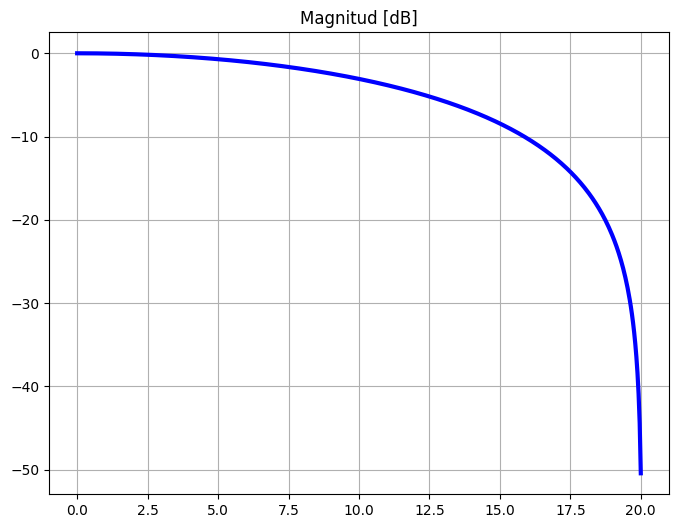

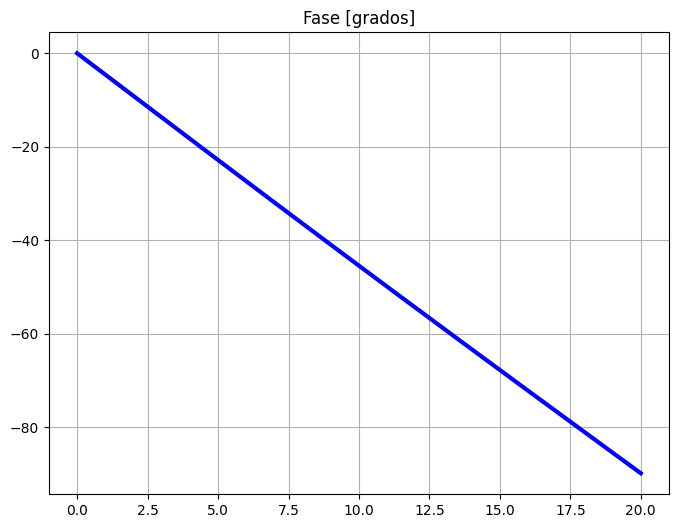

In [32]:
freqz_plot(b, a, sr)

### Error de corrimiento de frecuencia (Frequency warping)

$$\begin{align}
\omega_p &=& \dfrac{2}{T} tan \left(\dfrac{\omega T}{2}\right)\\\
&=& \dfrac{2}{T} tan (\pi f T)
  \end{align}$$

In [33]:
def freq_wrap(f, Ts):
    wp = 2/Ts * np.tan(np.pi * f * Ts)
    return wp

In [37]:
wp = freq_wrap(fc, P)
wp

119.72846101323913

con warping

In [38]:
Hz.subs({T: P, wc: wp})

2.99321152533098*(z + 1)/(4.99321152533098*z + 0.993211525330978)

sin warping

In [39]:
Hz.subs({T: P, wc: fcw})

1.96349540849362*(z + 1)/(3.96349540849362*z - 0.0365045915063791)

In [40]:
bwp = bn1(P, wp)
awp = an1(P, wp)
print(b)
print(a)

[1.963495408493621, 1.963495408493621]
[3.963495408493621, -0.03650459150637908]


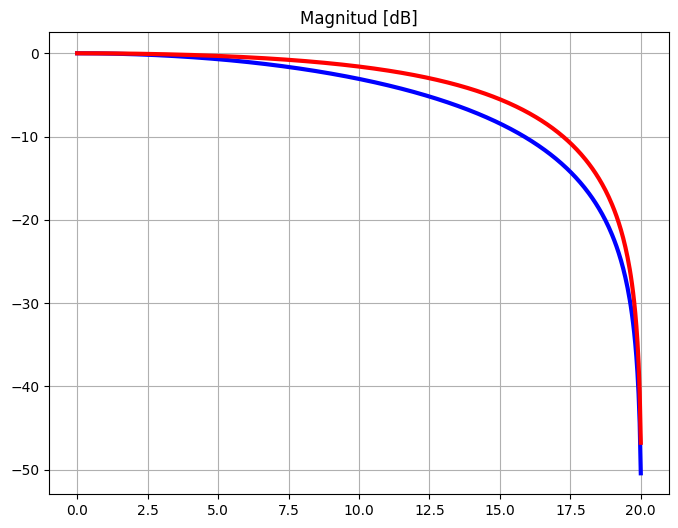

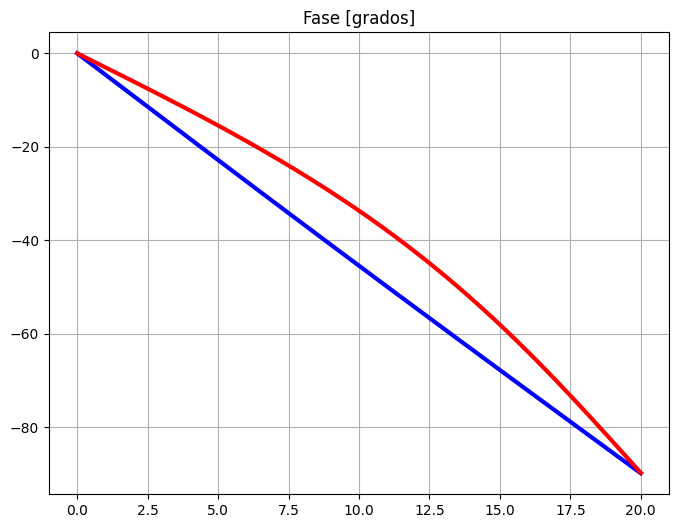

In [41]:
freqz_plot(b, a, sr)
freqz_plot(bwp, awp, sr, color='red')

#### Caso: no normalizado, orden 2

In [43]:
Hs = wc**2/(s**2 + np.sqrt(2)*s*wc + wc**2)
Hs

wc**2/(s**2 + 1.4142135623731*s*wc + wc**2)

In [44]:
Hz = bilinear(Hs)
Hz = Hz.simplify().expand().simplify().collect([z**2, z])
Hz

T**2*wc**2*(z**2 + 2*z + 1)/(T**2*wc**2 - 2.82842712474619*T*wc + z**2*(T**2*wc**2 + 2.82842712474619*T*wc + 4) + z*(2*T**2*wc**2 - 8) + 4)

In [45]:
bn2 = lambda P, w: [(w*P)**2, 2*(w*P)**2, (w*P)**2]
an2 = lambda P, w: [(P*w)**2 + 2.828427*P*w + 4,
                    2*(P*w)**2 - 8,
                    (P*w)**2 - 2.828427*P*w + 4]

In [46]:
wp = freq_wrap(fc, P)
Hz.subs({T: P, wc: wp})

8.9593152353742*(z**2 + 2*z + 1)/(21.4253959037233*z**2 + 9.9186304707484*z + 4.49323456702514)

In [47]:
bn2_nn = bn2(P, wp)
an2_nn = an2(P, wp)
#
print(bn2_nn)
print(an2_nn)

[8.959315235374202, 17.918630470748404, 8.959315235374202]
[21.425395530331524, 9.918630470748404, 4.49323494041688]


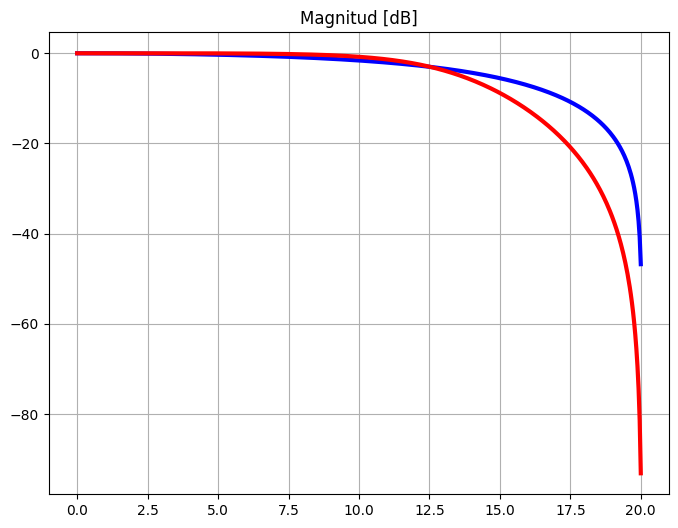

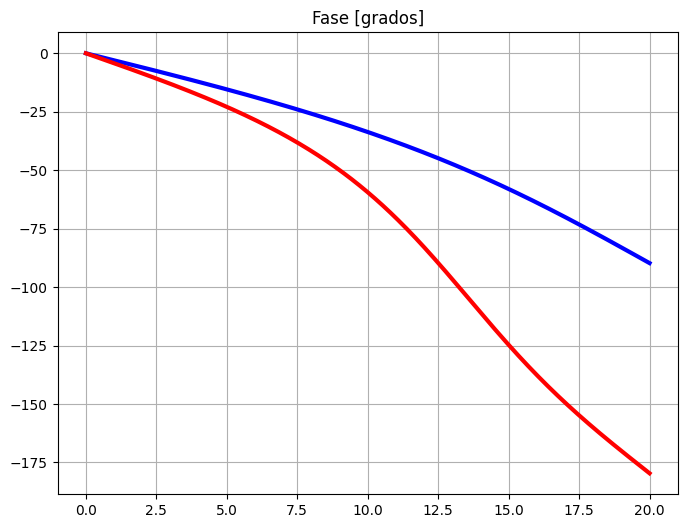

In [50]:
freqz_plot(bwp, awp, sr)
freqz_plot(bn2_nn, an2_nn, sr, color='red')

## Pasa altas Butterworth orden 2 no normalizado

In [51]:
Hs = (s*wc)**2/(s**2 + np.sqrt(2)*s*wc + wc**2)
Hs

s**2*wc**2/(s**2 + 1.4142135623731*s*wc + wc**2)

In [53]:
Hz = bilinear(Hs)
Hz = Hz.simplify().expand().simplify().collect([z**2, z])
Hz

4*wc**2*(z**2 - 2*z + 1)/(T**2*wc**2 - 2.82842712474619*T*wc + z**2*(T**2*wc**2 + 2.82842712474619*T*wc + 4) + z*(2*T**2*wc**2 - 8) + 4)

In [54]:
bn2 = lambda P, w: [4*w**2, -8*w**2, 4*w**2]
an2 = lambda P, w: [(P*w)**2 + 2.828427*P*w + 4,
                    2*(P*w)**2 - 8,
                    (P*w)**2 - 2.828427*P*w + 4]

In [55]:
wp = freq_wrap(fc, P)
Hz.subs({T: P, wc: wp})

57339.6175063949*(z**2 - 2*z + 1)/(21.4253959037233*z**2 + 9.9186304707484*z + 4.49323456702514)

In [56]:
bn2_nn = bn2(P, wp)
an2_nn = an2(P, wp)
#
print(bn2_nn)
print(an2_nn)

[57339.61750639488, -114679.23501278977, 57339.61750639488]
[21.425395530331524, 9.918630470748404, 4.49323494041688]


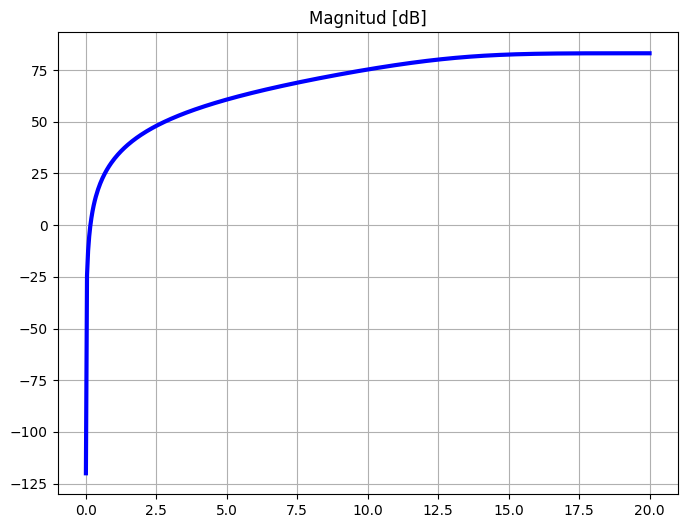

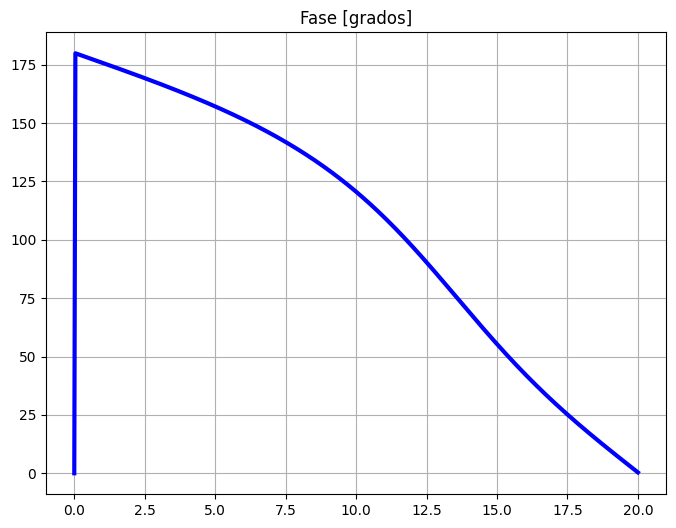

In [57]:
freqz_plot(bn2_nn, an2_nn, sr)

In [61]:
#IIR Impulse Infinity Response
fc = 0.1
wp = freq_wrap(fc, P)
bn2_nn = bn2(P, wp)
an2_nn = an2(P, wp)
#
print(bn2_nn)
print(an2_nn)

[1.5792016458383396, -3.158403291676679, 1.5792016458383396]
[4.044676491232925, -7.999506499485675, 3.955817009281399]


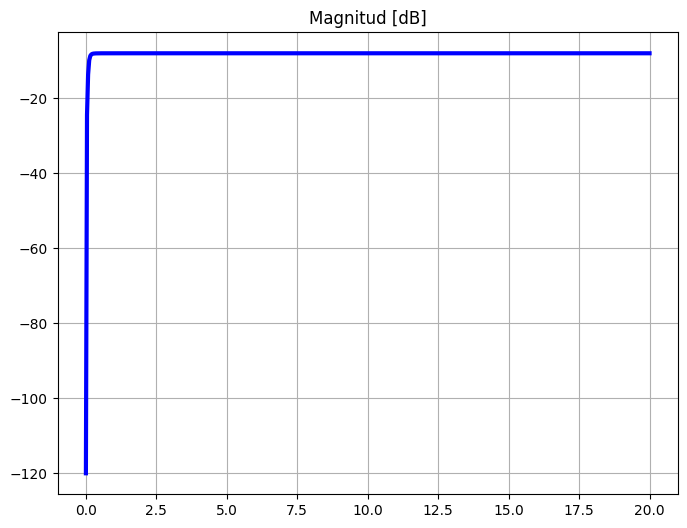

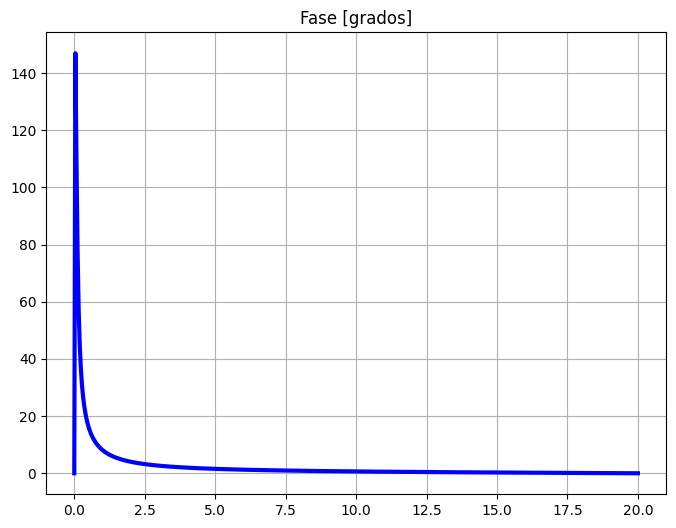

In [62]:
freqz_plot(bn2_nn, an2_nn, sr)